In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from LinearKalmanNet import LinearKalmanNet
from KalmanNet import KalmanNet
from utils import generate_data, train
from Kalman import KalmanFilter
from ExtendedKalmanFilter import ExtendedKalmanFilter
from LinearSystem import LinearSystem
from NonLinearSystem import NonlinearSystem

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


# Testování hyperparametrů batch_size

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 

batch_sizes_to_test = [16, 32, 64, 128, 256] 
num_runs = 5
epochs = 30
lr = 1e-4

results = []

for run in range(num_runs):
    print(f"\n{'='*20} BĚH EXPERIMENTU č. {run + 1}/{num_runs} {'='*20}")
    
    print("Generuji novou sadu trénovacích a testovacích dat...")
    F_true = torch.tensor([[0.9]])
    H_true = torch.tensor([[1.0]])
    Q_true = torch.tensor([[0.1]])
    R_true = torch.tensor([[0.1]])
    Ex0_true = torch.tensor([[1.0]])
    P0_true = torch.tensor([[2.0]])
    sys_true = LinearSystem(Ex0_true, P0_true, F_true, H_true, Q_true, R_true)
    
    F_model = torch.tensor([[0.8]])
    H_model = torch.tensor([[0.8]])
    sys_model = LinearSystem(None, None, F_model, H_model, None, None)

    x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
    x_test, y_test = generate_data(sys_true, num_trajectories=100, seq_len=200)
    
    train_dataset = TensorDataset(x_train, y_train)

    for bs in batch_sizes_to_test:
        print(f"\n--- Testuji Batch Size = {bs} ---")
        
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        knet = LinearKalmanNet(sys_model, hidden_dim=64).to(device)
        train(knet, train_loader, device, epochs=epochs, lr=lr)
        
        knet.eval()
        with torch.no_grad():
            y_test_device = y_test.to(device)
            x_hat_knet_device = knet(y_test_device)
            x_hat_knet = x_hat_knet_device.cpu()
        
        mse = nn.MSELoss()(x_hat_knet, x_test).item()
        
        if np.isfinite(mse):
            print(f"Výsledná MSE pro Batch Size {bs}: {mse:.6f}")
            results.append({'run': run + 1, 'batch_size': bs, 'mse': mse})
        else:
            print(f"ERROR: Trénování pro Batch Size {bs} selhalo. Výsledná MSE je {mse}.")
            results.append({'run': run + 1, 'batch_size': bs, 'mse': np.nan})



==================== BĚH EXPERIMENTU č. 1/5 ====================
Generuji novou sadu trénovacích a testovacích dat...

--- Testuji Batch Size = 16 ---
Zahajuji trénování KalmanNetu...
Epocha [10/30], Prům. chyba: 2089260363511724244992.000000, Prům. norma grad.: inf
Epocha [20/30], Prům. chyba: 2080558304633298354176.000000, Prům. norma grad.: inf
Epocha [30/30], Prům. chyba: 2089841411915210555392.000000, Prům. norma grad.: inf
Trénování dokončeno.
ERROR: Trénování pro Batch Size 16 selhalo. Výsledná MSE je inf.

--- Testuji Batch Size = 32 ---
Zahajuji trénování KalmanNetu...
Epocha [10/30], Prům. chyba: 5815066271073712472064.000000, Prům. norma grad.: inf
Epocha [20/30], Prům. chyba: 0.066716, Prům. norma grad.: 0.0306
Epocha [30/30], Prům. chyba: 0.064354, Prům. norma grad.: 0.0365
Trénování dokončeno.
Výsledná MSE pro Batch Size 32: 0.062260

--- Testuji Batch Size = 64 ---
Zahajuji trénování KalmanNetu...
Epocha [10/30], Prům. chyba: 0.069675, Prům. norma grad.: 0.0469
Epocha [


--- Finální výsledky experimentu ---
Statistiky z úspěšných běhů:
                mean       std       min       max  count
batch_size                                               
16          0.061985  0.000405  0.061534  0.062485      4
32          0.062601  0.000532  0.062020  0.063413      5
64          0.063780  0.000756  0.062614  0.064676      5
128         0.064572       NaN  0.064572  0.064572      1
256         0.067041  0.001647  0.065394  0.069546      5


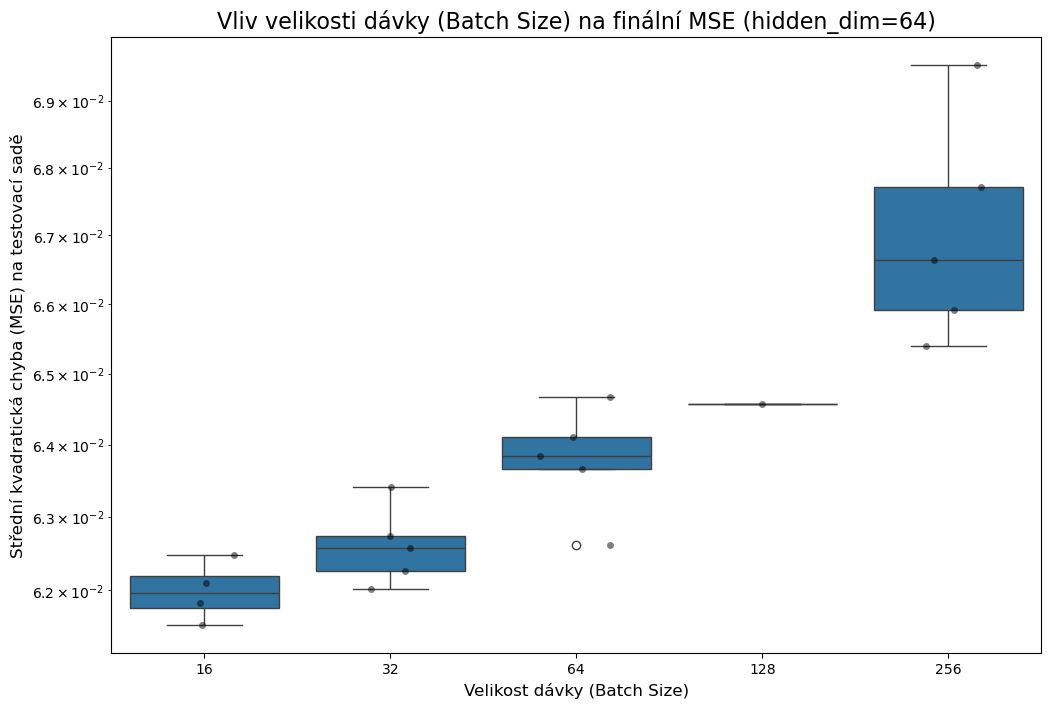

In [ ]:
print("\n--- Finální výsledky experimentu ---")

results_df = pd.DataFrame(results)

valid_results_df = results_df.dropna()

if valid_results_df.empty:
    print("Všechny běhy selhaly. Nelze vykreslit graf ani zobrazit statistiky.")
else:
    print("Statistiky z úspěšných běhů:")
    avg_results = valid_results_df.groupby('batch_size')['mse'].agg(['mean', 'std', 'min', 'max', 'count'])
    print(avg_results)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='batch_size', y='mse', data=valid_results_df)
    sns.stripplot(x='batch_size', y='mse', data=valid_results_df, color='black', alpha=0.5, jitter=0.2)

    plt.title('Vliv velikosti dávky (Batch Size) na finální MSE (hidden_dim=64)', fontsize=16)
    plt.xlabel('Velikost dávky (Batch Size)', fontsize=12)
    plt.ylabel('Střední kvadratická chyba (MSE) na testovací sadě', fontsize=12)
    plt.yscale('log')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()